In [16]:
from pathlib import Path
from pandas import DataFrame
from scipy.stats import lognorm
from numpy import exp
from json import loads

In [17]:
INSTANCE_DATA_PATH = Path("~/Downloads/mastodon").expanduser()
ACTIVITY_COLS = {
    "total_users": lognorm,
    "total_posts": lognorm,
    "mean_weekly_posts": lognorm,
    "mean_weekly_logins": lognorm,
    "mean_weekly_registrations": lognorm,
}
NUM_SAMPLES = 100
SAMPLED_INSTANCES_OUTPUT_PATH = Path("sampled_instances.txt")

In [18]:
with INSTANCE_DATA_PATH.open() as file:
    lines_split = (
        line.split(maxsplit=1)
        for line in file
    )
    lines_dicts = (
        {
            "instance": line_split[0],
            **loads(line_split[1])
        }
        for line_split in lines_split
        if len(line_split) > 1
    )
    df = DataFrame([
        {
            "instance": lines_dict["instance"],
            "total_users": lines_dict["nodeinfo"]["usage"]["users"]["total"],
            "total_posts": lines_dict["nodeinfo"]["usage"]["localPosts"],
            "week": activity["week"],
            "week_posts": activity["statuses"],
            "week_logins": activity["logins"],
            "week_registrations": activity["registrations"],
        }
        for lines_dict in lines_dicts
        for activity in lines_dict["activity"]
    ])
del df["week"]
df = df.groupby(["instance", "total_users", "total_posts"]).mean().reset_index()
df.rename(columns={"week_posts": "mean_weekly_posts", "week_logins": "mean_weekly_logins", "week_registrations": "mean_weekly_registrations"}, inplace=True)

# # Remove empty instances:
# df = df[df["total_users"] > 0]
# df = df[df["total_posts"] > 0]
df

,instance,total_users,total_posts,mean_weekly_posts,mean_weekly_logins,mean_weekly_registrations
0,0371.uk,1,112,4.833333,0.666667,0.083333
1,0x3c.pl,91,2305,1.083333,5.333333,0.333333
2,0x4655.co.uk,1,0,0.000000,0.083333,0.000000
3,0x50.ch,1,2,0.000000,0.000000,0.000000
4,0xee.io,16,199,0.583333,1.416667,0.000000
...,...,...,...,...,...,...
9623,zusammenhalt.de,1,36,6.083333,1.000000,0.000000
9624,zusammenkunft.net,2,5110,54.083333,2.000000,0.000000
9625,zweibruecken.social,3,495,3.333333,1.416667,0.000000
9626,zx81.social,1,530,4.916667,1.000000,0.000000


array([[<Axes: title={'center': 'total_users'}>,
        <Axes: title={'center': 'total_posts'}>],
       [<Axes: title={'center': 'mean_weekly_posts'}>,
        <Axes: title={'center': 'mean_weekly_logins'}>],
       [<Axes: title={'center': 'mean_weekly_registrations'}>, <Axes: >]],
      dtype=object)

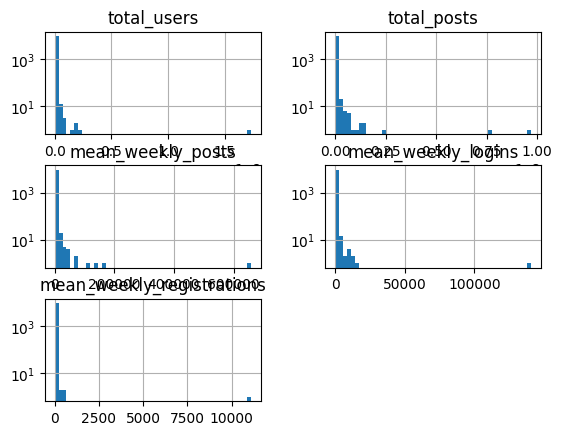

In [19]:
df[ACTIVITY_COLS.keys()].hist(log=True, bins=50)

In [20]:
# Estimate probability distributions over activity columns
distributions = {
    col: dist.fit(df[col])
    for col, dist in ACTIVITY_COLS.items()
}
distributions

/home/heinrich/Repositories/sigir24-rank-fusion-evaluation/venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6120: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/home/heinrich/Repositories/sigir24-rank-fusion-evaluation/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/heinrich/Repositories/sigir24-rank-fusion-evaluation/venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


{'total_users': (2.0370605170730993,
  -0.004859465990659667,
  6.1020901792891395),
 'total_posts': (1.4198638517512898, -1301.923191523214, 3121.9460808564977),
 'mean_weekly_posts': (315.0488777653591, -5e-324, 5.649938568532456e-75),
 'mean_weekly_logins': (167.0487612894954, -5e-324, 1.3081616262676516e-17),
 'mean_weekly_registrations': (332.982884256676,
  -5e-324,
  2.597542355465859e-234)}

In [21]:
# Compute normalize activity score by dividing by the estimated probability.
for col, dist in ACTIVITY_COLS.items():
    shape, location, scale = distributions[col]
    df[f"{col}_log_probability"] = dist.logpdf(df[col], shape, location, scale)

# Compute joint probability (under assumption of independence; using log probabilities for numerical stability)
df["log_probability"] = 0
for col in ACTIVITY_COLS.keys():
    df["log_probability"] += df[f"{col}_log_probability"]

df.sort_values("log_probability", inplace=True)
df

,instance,total_users,total_posts,mean_weekly_posts,mean_weekly_logins,mean_weekly_registrations,total_users_log_probability,total_posts_log_probability,mean_weekly_posts_log_probability,mean_weekly_logins_log_probability,mean_weekly_registrations_log_probability,log_probability
4670,mastodon.social,1731177,76561255,657075.083333,140710.583333,11072.583333,-34.989906,-44.760171,-20.238433,-17.937796,-17.389335,-135.315641
5480,mstdn.social,219348,14341831,114326.416667,14598.583333,509.416667,-27.187385,-35.384136,-18.486460,-15.667989,-14.295223,-111.021192
4425,mastodon.online,194387,7290115,78361.583333,12827.000000,628.166667,-26.762945,-31.991124,-18.108042,-15.538392,-14.505790,-106.906293
3146,mas.to,167800,6609680,73512.583333,11334.916667,196.166667,-26.250957,-31.518645,-18.044047,-15.414514,-13.336242,-104.564405
1625,fedibird.com,38365,13553759,132622.500000,10115.583333,154.666667,-21.402735,-35.092042,-18.635182,-15.300506,-13.097386,-103.527851
...,...,...,...,...,...,...,...,...,...,...,...,...
6363,radiostatler.social,1,0,0.000000,0.000000,0.000000,-2.027335,-8.630816,736.111692,729.483004,737.520581,2192.457127
7204,social.disputemag.com,1,0,0.000000,0.000000,0.000000,-2.027335,-8.630816,736.111692,729.483004,737.520581,2192.457127
3418,mastodon.alex.net,1,0,0.000000,0.000000,0.000000,-2.027335,-8.630816,736.111692,729.483004,737.520581,2192.457127
3409,mastodon.aftbit.com,1,0,0.000000,0.000000,0.000000,-2.027335,-8.630816,736.111692,729.483004,737.520581,2192.457127


In [22]:
df["weight"] = exp(-df["log_probability"])
df_sample = df.sample(n=NUM_SAMPLES, replace=False, weights=df["weight"])
df_sample

,instance,total_users,total_posts,mean_weekly_posts,mean_weekly_logins,mean_weekly_registrations,total_users_log_probability,total_posts_log_probability,mean_weekly_posts_log_probability,mean_weekly_logins_log_probability,mean_weekly_registrations_log_probability,log_probability,weight
4670,mastodon.social,1731177,76561255,657075.083333,140710.583333,11072.583333,-34.989906,-44.760171,-20.238433,-17.937796,-17.389335,-135.315641,5.845699e+58
4425,mastodon.online,194387,7290115,78361.583333,12827.000000,628.166667,-26.762945,-31.991124,-18.108042,-15.538392,-14.505790,-106.906293,2.684188e+46
5480,mstdn.social,219348,14341831,114326.416667,14598.583333,509.416667,-27.187385,-35.384136,-18.486460,-15.667989,-14.295223,-111.021192,1.643960e+48
4893,mastodon.world,181076,4547385,48850.250000,11164.833333,355.750000,-26.515368,-29.759151,-17.634601,-15.399369,-13.934423,-103.242911,6.883775e+44
1625,fedibird.com,38365,13553759,132622.500000,10115.583333,154.666667,-21.402735,-35.092042,-18.635182,-15.300506,-13.097386,-103.527851,9.153233e+44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764,liker.social,3345,447219,1233.916667,215.833333,4.083333,-14.538054,-20.403220,-13.949367,-11.446815,-9.445292,-69.782747,2.024240e+30
6338,queer.party,6145,1012783,4075.333333,386.666667,0.500000,-16.115092,-23.394177,-15.146277,-12.030802,-7.335037,-74.021385,1.403069e+32
2568,kemonodon.club,2912,759631,2687.916667,569.333333,3.750000,-14.191059,-22.303564,-14.729340,-12.418329,-9.359720,-73.002011,5.062563e+31
2615,kmy.blue,2175,247747,5932.000000,617.250000,12.666667,-13.475762,-18.451155,-15.522364,-12.499268,-10.582864,-70.531413,4.279603e+30


array([[<Axes: title={'center': 'total_users'}>,
        <Axes: title={'center': 'total_posts'}>],
       [<Axes: title={'center': 'mean_weekly_posts'}>,
        <Axes: title={'center': 'mean_weekly_logins'}>],
       [<Axes: title={'center': 'mean_weekly_registrations'}>, <Axes: >]],
      dtype=object)

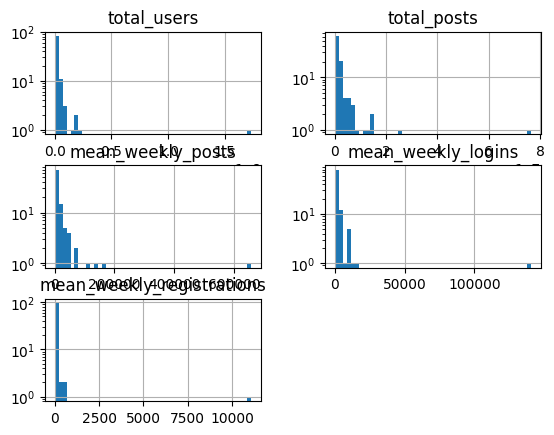

In [23]:
df_sample[ACTIVITY_COLS.keys()].hist(log=True, bins=50)

In [24]:
instances = df_sample["instance"].sort_values()
instances.to_csv(SAMPLED_INSTANCES_OUTPUT_PATH, index=False, header=False)
instances.to_frame()

,instance
72,abdl.link
111,aethy.com
359,aus.social
386,awscommunity.social
488,berlin.social
...,...
9294,vocalodon.net
9344,wandering.shop
9393,wetdry.world
9510,wxw.moe
